# Finansal Risk Analizi

Bu çalışmanın amacı seçilen hisse senetlerinin risk ve getirilerini hesaplamak, getirileri aralarındaki ilişkileri incelemek, bu hisse senetlerinden portfoy oluşturup portfoyun risk ve getirisini heaplamak, Markowitz'in portföy teorisinden yola çıkarak risk ve getiri tercihine göre en uygun portfoy ağırlıklandırmalarını bulmak, CAPM modeli oluşturularak bir hisse senedinin yıllık getiri beklentisini ortaya koymak ve monte carlo yöntemi ile bir hisse senedine ait 100 günlük fiyat hareketi simülasyonu oluşturmaktır.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from scipy.stats import norm
%matplotlib inline

Hisse senetlerinin 10 yıllık günlük fiyatlarını yahoo finance veritabanından alalım:

In [2]:
tickers=["AKSA.IS","AKSEN.IS","DOAS.IS","TKNSA.IS","MGROS.IS","FROTO.IS"]
mydata=pd.DataFrame()
for t in tickers:
    mydata[t]=yf.download(t,start="2013-1-1",progress=False)["Adj Close"]

In [3]:
mydata.head()

,AKSA.IS,AKSEN.IS,DOAS.IS,TKNSA.IS,MGROS.IS,FROTO.IS
Date,,,,,,
2013-01-01,1.241406,2.233685,3.314460,7.267702,21.500000,12.720519
2013-01-02,1.265558,2.214092,3.322186,7.286980,21.850000,12.690798
2013-01-03,1.255898,2.204295,3.322186,7.267702,22.150000,12.453030
2013-01-04,1.236576,2.184701,3.383995,7.286980,22.049999,12.244986
2013-01-07,1.260728,2.174904,3.430351,7.286980,22.250000,12.631358


In [4]:
mydata.tail()

,AKSA.IS,AKSEN.IS,DOAS.IS,TKNSA.IS,MGROS.IS,FROTO.IS
Date,,,,,,
2023-04-19,70.800003,33.299999,126.500000,18.139999,182.699997,588.500000
2023-04-20,70.400002,32.619999,125.599998,17.790001,183.800003,583.000000
2023-04-24,70.800003,32.720001,130.699997,18.049999,183.800003,581.000000
2023-04-25,70.699997,30.639999,125.699997,17.370001,180.100006,566.599976
2023-04-26,69.250000,30.400000,124.300003,17.059999,177.000000,564.000000


In [5]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2656 entries, 2013-01-01 to 2023-04-26
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AKSA.IS   2656 non-null   float64
 1   AKSEN.IS  2656 non-null   float64
 2   DOAS.IS   2656 non-null   float64
 3   TKNSA.IS  2656 non-null   float64
 4   MGROS.IS  2656 non-null   float64
 5   FROTO.IS  2656 non-null   float64
dtypes: float64(6)
memory usage: 145.2 KB


Hisse senetlerinin zaman serisi grafiği

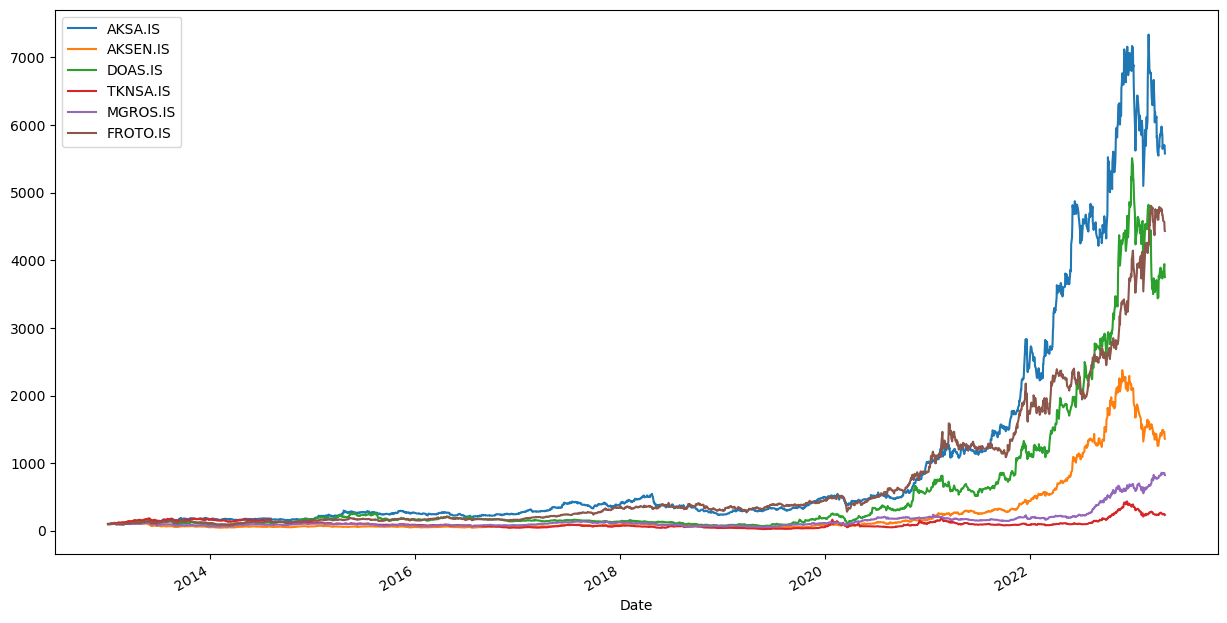

In [6]:
(mydata/mydata.iloc[0]*100).plot(figsize=(15,8));
plt.show()

In [7]:
normalize=mydata/mydata.iloc[0]*100
normalize.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10',
               '2013-01-11', '2013-01-14',
               ...
               '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-17',
               '2023-04-18', '2023-04-19', '2023-04-20', '2023-04-24',
               '2023-04-25', '2023-04-26'],
              dtype='datetime64[ns]', name='Date', length=2656, freq=None)

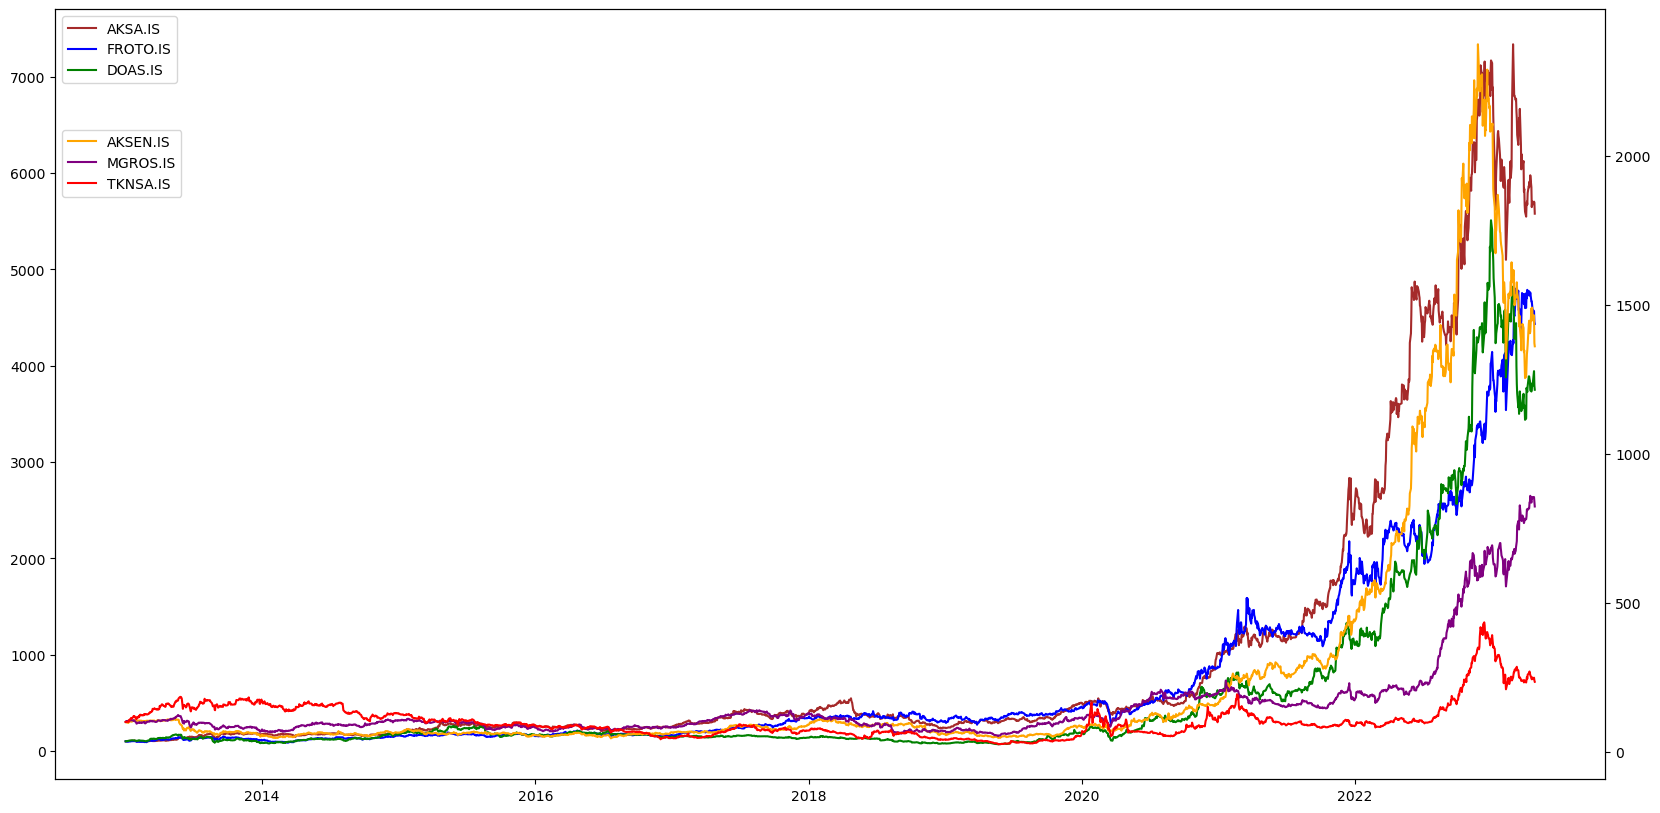

In [8]:
fig, ax1=plt.subplots(figsize=(20,10))
ax1.plot(normalize.index, normalize["AKSA.IS"], color="brown", linewidth=1.5, label="AKSA.IS")
ax1.plot(normalize.index, normalize["FROTO.IS"], color="blue", linewidth=1.5, label="FROTO.IS")
ax1.plot(normalize.index, normalize["DOAS.IS"], color="green", linewidth=1.5, label="DOAS.IS")
ax2 = ax1.twinx()
ax2.plot(normalize.index, normalize["AKSEN.IS"], color="orange", linewidth=1.5, label="AKSEN.IS")
ax2.plot(normalize.index, normalize["MGROS.IS"], color="purple", linewidth=1.5, label="MGROS.IS")
ax2.plot(normalize.index, normalize["TKNSA.IS"], color="red", linewidth=1.5, label="TKNSA.IS")
ax1.legend()
ax2.legend(loc='center left', bbox_to_anchor=(0, 0.8))
plt.show()

## Getirilerin Hesaplanması

In [9]:
returns=np.log(mydata/mydata.shift(1))
returns

,AKSA.IS,AKSEN.IS,DOAS.IS,TKNSA.IS,MGROS.IS,FROTO.IS
Date,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0.019269,-0.008811,0.002328,0.002649,0.016148,-0.002339
2013-01-03,-0.007663,-0.004435,0.000000,-0.002649,0.013637,-0.018913
2013-01-04,-0.015504,-0.008929,0.018434,0.002649,-0.004525,-0.016847
2013-01-07,0.019343,-0.004494,0.013606,0.000000,0.009029,0.031066
...,...,...,...,...,...,...
2023-04-19,0.009936,0.029871,0.019961,0.026817,0.000000,-0.008797
2023-04-20,-0.005666,-0.020632,-0.007140,-0.019483,0.006003,-0.009390
2023-04-24,0.005666,0.003061,0.039802,0.014509,0.000000,-0.003436


In [10]:
# yıllık getiriler (250 iş günü):
print(returns["AKSA.IS"].mean()*250)
print(returns["AKSEN.IS"].mean()*250)
print(returns["DOAS.IS"].mean()*250)
print(returns["TKNSA.IS"].mean()*250)
print(returns["MGROS.IS"].mean()*250)
print(returns["FROTO.IS"].mean()*250)

0.3786702709819044
0.24583707033171767
0.3412809062980814
0.08034805542287513
0.19850252329945509
0.35704688204844126


In [11]:
# yıllık riskler (240 iş günü):
print(returns["AKSA.IS"].std()*250**0.5)
print(returns["AKSEN.IS"].std()*250**0.5)
print(returns["DOAS.IS"].std()*250**0.5)
print(returns["TKNSA.IS"].std()*250**0.5)
print(returns["MGROS.IS"].std()*250**0.5)
print(returns["FROTO.IS"].std()*250**0.5)

0.36871415509532685
0.39375808630195824
0.4710369059836666
0.5173157302043508
0.3582086117300353
0.3797947215290843


## Kovaryans ve Korelasyon Matrisleri

In [12]:
cov_matrix_a=returns.cov()*250
cov_matrix_a

,AKSA.IS,AKSEN.IS,DOAS.IS,TKNSA.IS,MGROS.IS,FROTO.IS
AKSA.IS,0.135950,0.060824,0.062675,0.060529,0.047827,0.047007
AKSEN.IS,0.060824,0.155045,0.073349,0.069125,0.057167,0.050862
DOAS.IS,0.062675,0.073349,0.221876,0.085859,0.066863,0.068711
TKNSA.IS,0.060529,0.069125,0.085859,0.267616,0.062425,0.054773
MGROS.IS,0.047827,0.057167,0.066863,0.062425,0.128313,0.048643
FROTO.IS,0.047007,0.050862,0.068711,0.054773,0.048643,0.144244


In [13]:
corr_matrix_a=returns.corr()
corr_matrix_a

,AKSA.IS,AKSEN.IS,DOAS.IS,TKNSA.IS,MGROS.IS,FROTO.IS
AKSA.IS,1.000000,0.418945,0.360870,0.317333,0.362117,0.335680
AKSEN.IS,0.418945,1.000000,0.395466,0.339350,0.405306,0.340106
DOAS.IS,0.360870,0.395466,1.000000,0.352352,0.396272,0.384080
TKNSA.IS,0.317333,0.339350,0.352352,1.000000,0.336871,0.278781
MGROS.IS,0.362117,0.405306,0.396272,0.336871,1.000000,0.357547
FROTO.IS,0.335680,0.340106,0.384080,0.278781,0.357547,1.000000


In [14]:
import pingouin as pg
import seaborn as sns

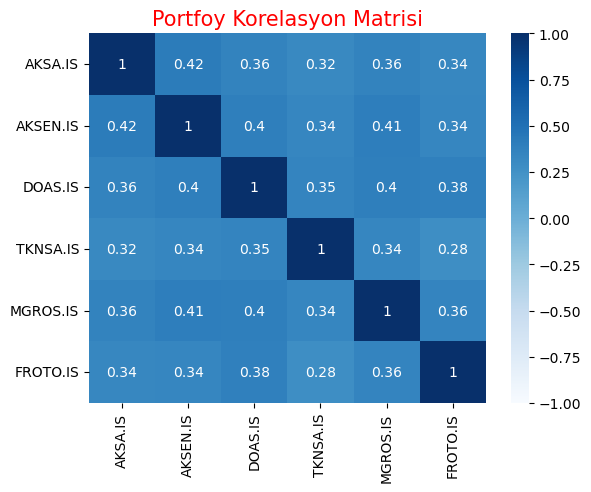

In [15]:
plt.title("Portfoy Korelasyon Matrisi", color="red", fontsize=15)
sns.heatmap(corr_matrix_a, annot=True, cmap="Blues", xticklabels=True, yticklabels=True, vmin=-1, vmax=1)
plt.show()

Korelasyonların istatiksel olarak anlamlı olup olmadığının test edilmesi:

In [16]:
anlam=pg.pairwise_corr(returns)
pd.set_option("display.max_rows",None)
print(anlam)

           X         Y   method alternative     n         r         CI95%  \
0    AKSA.IS  AKSEN.IS  pearson   two-sided  2655  0.418945  [0.39, 0.45]   
1    AKSA.IS   DOAS.IS  pearson   two-sided  2655  0.360870  [0.33, 0.39]   
2    AKSA.IS  TKNSA.IS  pearson   two-sided  2655  0.317333  [0.28, 0.35]   
3    AKSA.IS  MGROS.IS  pearson   two-sided  2655  0.362117  [0.33, 0.39]   
4    AKSA.IS  FROTO.IS  pearson   two-sided  2655  0.335680   [0.3, 0.37]   
5   AKSEN.IS   DOAS.IS  pearson   two-sided  2655  0.395466  [0.36, 0.43]   
6   AKSEN.IS  TKNSA.IS  pearson   two-sided  2655  0.339350  [0.31, 0.37]   
7   AKSEN.IS  MGROS.IS  pearson   two-sided  2655  0.405306  [0.37, 0.44]   
8   AKSEN.IS  FROTO.IS  pearson   two-sided  2655  0.340106  [0.31, 0.37]   
9    DOAS.IS  TKNSA.IS  pearson   two-sided  2655  0.352352  [0.32, 0.39]   
10   DOAS.IS  MGROS.IS  pearson   two-sided  2655  0.396272  [0.36, 0.43]   
11   DOAS.IS  FROTO.IS  pearson   two-sided  2655  0.384080  [0.35, 0.42]   

In [17]:
print(anlam[anlam["p-unc"]>0.05])

Empty DataFrame
Columns: [X, Y, method, alternative, n, r, CI95%, p-unc, BF10, power]
Index: []


%95 güven düzeyinden anlamsız korelasyon yoktur. Hisse senetlerinin birbirleriyle olan korelasyonları istatiksel olarak anlamlıdır.

## Portfoyün Beklenen Getirisi ve Riski

Random ağırlıklar ile portfoy oluşturalım. Daha sonra Markowitz yöntemi ile risk ve getiri beklentimize göre optimal ağırlıklandırmaları belirleyeceğiz.

In [18]:
num_assets=len(tickers)
weights=np.random.random(num_assets)
weights/=np.sum(weights)
weights

array([0.16569341, 0.17522495, 0.26980283, 0.14319643, 0.04479573,
       0.20128665])

In [19]:
## Portfoyun beklenen getirsi:
np.sum(weights*returns.mean())*250

0.29016490118168015

In [20]:
## Beklenen Portfoy Varyansı:
np.dot(weights.T, np.dot(returns.cov()*250,weights))

0.08752536620630916

In [21]:
## Beklenen Portfoy Volatilesi
np.sqrt(np.dot(weights.T, np.dot(returns.cov()*250,weights)))

0.29584686276232364

Random ağırlıklandırmalar ile 1000 iterasyonda oluşacak portfoy getiri ve risklerini gözlemleyelim:

In [22]:
w=[]
pfolio_returns=[]
pfolio_volatilities=[]

for i in range(1000):
    weights=np.random.random(num_assets)
    w.append(weights/np.sum(weights))
    pfolio_returns.append(np.sum(w[i]*returns.mean())*250)
    pfolio_volatilities.append(np.sqrt(np.dot(w[i].T, np.dot(returns.cov()*250,w[i]))))
    
pfolio_returns=np.array(pfolio_returns)
pfolio_volatilities=np.array(pfolio_volatilities)

portfolios=pd.DataFrame({"Return":pfolio_returns, "Volatility":pfolio_volatilities})
portfolios.head()

,Return,Volatility
0,0.248864,0.289577
1,0.277938,0.298476
2,0.321976,0.298263
3,0.238476,0.283937
4,0.270050,0.284864


Text(0, 0.5, 'Expected Return')

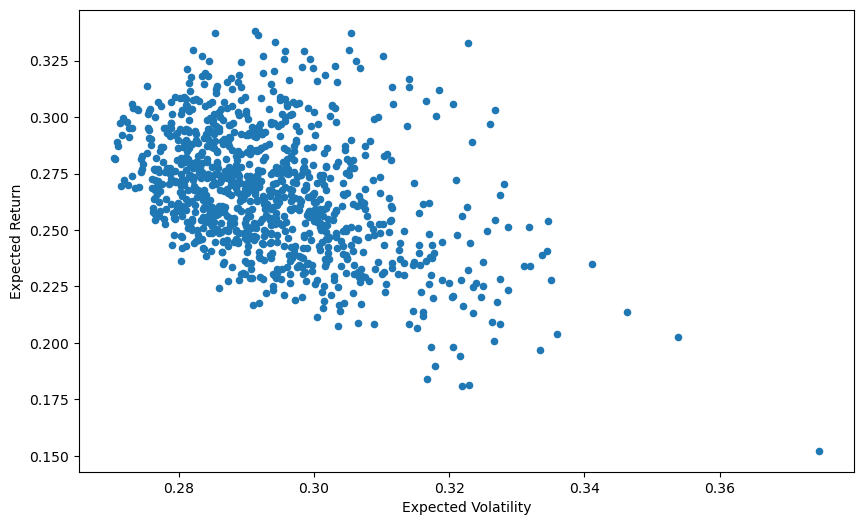

In [23]:
portfolios.plot(x="Volatility",y="Return",kind="scatter",figsize=(10,6))
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Return")

Riks ve getiri tercihimizin 0.25 üstü getiri ve 0.27 altı risk olduğu varsayımıyla tüm bu koşula uyan risk ve getirilere bakalım:

In [29]:
portfolios[(portfolios["Return"]>0.25) & (portfolios["Volatility"]<0.271)]

,Return,Volatility
231,0.287190,0.270975
426,0.281969,0.270441
542,0.289104,0.270896
986,0.281556,0.270566


Bir tane mevcut ve bu koşulu sağlayan ağırlıklandırma:

In [30]:
w[426]

array([0.27653616, 0.119836  , 0.01968905, 0.08814258, 0.27141569,
       0.22438051])

## Beta, CAPM ve CAPM ile Yıllık Beklenen Getirinin Hesaplanması

In [31]:
endeks=yf.download("XU100.IS",start="2013-1-1",progress=False)["Adj Close"]

[]

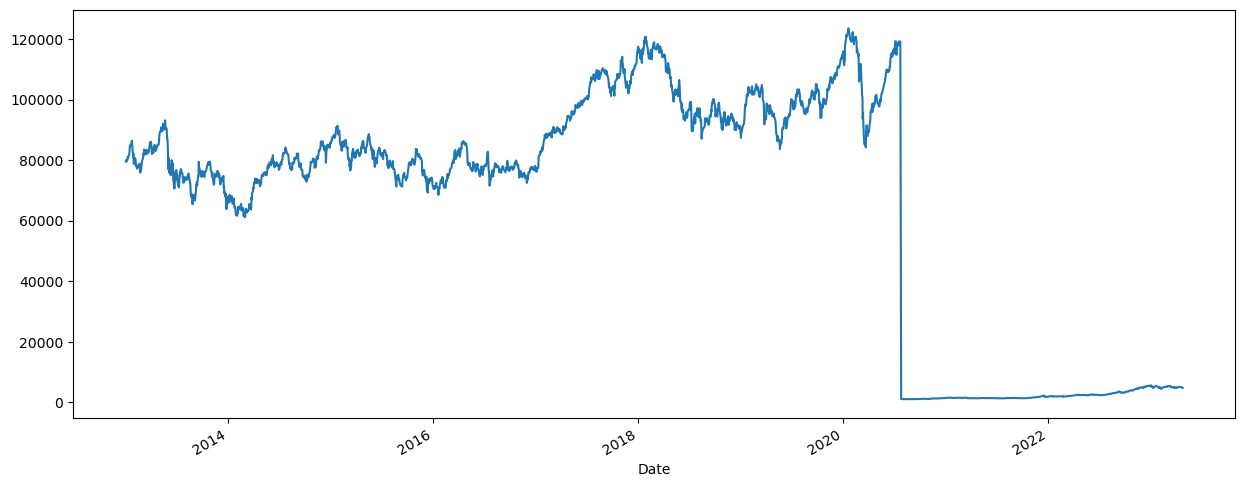

In [32]:
endeks.plot(figsize=(15,6));
plt.plot()

Endeksten 2 sıfır atılıdğı için düzenleme yapmaya ihtiyaç vardır.

In [33]:
endeks.loc["2020-07-27":] #endeksden 2 sıfır atıldığı tarih

Date
2020-07-27    1195.699951
2020-07-28    1152.699951
2020-07-29    1135.599976
2020-07-30    1126.900024
2020-08-04    1087.199951
2020-08-05    1091.800049
2020-08-06    1034.400024
2020-08-07    1060.599976
2020-08-10    1075.500000
2020-08-11    1110.099976
2020-08-12    1114.199951
2020-08-13    1100.300049
2020-08-14    1083.800049
2020-08-17    1086.199951
2020-08-18    1092.500000
2020-08-19    1124.699951
2020-08-20    1126.800049
2020-08-21    1109.900024
2020-08-24    1108.400024
2020-08-25    1092.199951
2020-08-26    1099.000000
2020-08-27    1108.900024
2020-08-28    1100.599976
2020-08-31    1078.599976
2020-09-01    1085.199951
2020-09-02    1083.900024
2020-09-03    1076.300049
2020-09-04    1086.300049
2020-09-07    1096.800049
2020-09-08    1089.599976
2020-09-09    1099.699951
2020-09-10    1099.099976
2020-09-11    1102.699951
2020-09-14    1107.300049
2020-09-15    1111.199951
2020-09-16    1107.099976
2020-09-17    1110.699951
2020-09-18    1112.000000
2020-09

In [34]:
endeks.loc["2013-01-02":"2020-07-24"] # 2 sıfır atılmadan önce

Date
2013-01-02     79642.101562
2013-01-03     80033.296875
2013-01-04     79564.000000
2013-01-07     80224.398438
2013-01-08     80161.703125
2013-01-09     81149.101562
2013-01-10     80837.500000
2013-01-11     81033.500000
2013-01-14     81990.000000
2013-01-15     82406.101562
2013-01-16     84082.203125
2013-01-17     84860.296875
2013-01-18     85004.898438
2013-01-21     85281.500000
2013-01-22     85646.898438
2013-01-23     86341.000000
2013-01-24     86437.898438
2013-01-25     84755.101562
2013-01-28     81165.796875
2013-01-29     82178.296875
2013-01-30     78982.898438
2013-01-31     78783.500000
2013-02-01     80221.703125
2013-02-04     80722.703125
2013-02-05     80309.898438
2013-02-06     80054.398438
2013-02-07     78149.296875
2013-02-08     78684.000000
2013-02-11     77255.796875
2013-02-12     78078.796875
2013-02-13     77943.398438
2013-02-14     77580.500000
2013-02-15     78081.398438
2013-02-18     77907.500000
2013-02-19     78274.898438
2013-02-20     

In [35]:
tickers2=["AKSA.IS","AKSEN.IS","DOAS.IS","TKNSA.IS","MGROS.IS","FROTO.IS","XU100.IS"]
mydata2=pd.DataFrame()
for t in tickers2:
    mydata2[t]=yf.download(t,start="2018-1-3",progress=False)["Adj Close"]

In [36]:
mydata2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1350 entries, 2018-01-03 to 2023-04-26
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AKSA.IS   1350 non-null   float64
 1   AKSEN.IS  1350 non-null   float64
 2   DOAS.IS   1350 non-null   float64
 3   TKNSA.IS  1350 non-null   float64
 4   MGROS.IS  1350 non-null   float64
 5   FROTO.IS  1350 non-null   float64
 6   XU100.IS  1326 non-null   float64
dtypes: float64(7)
memory usage: 84.4 KB


In [37]:
e1=mydata2.loc[:"2020-07-24"]
e2=mydata2.loc["2020-07-27":]
e1["Duzeltme"]=100
e2["Duzeltme"]=1
mydata2=pd.concat([e1,e2],axis=0)
mydata2["XU100"]=mydata2["XU100.IS"]/mydata2["Duzeltme"]
mydata2.drop(columns=["XU100.IS","Duzeltme"], inplace=True)
mydata2.head()

C:\Users\okand\AppData\Local\Temp\ipykernel_8548\3270768814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e1["Duzeltme"]=100
C:\Users\okand\AppData\Local\Temp\ipykernel_8548\3270768814.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e2["Duzeltme"]=1


,AKSA.IS,AKSEN.IS,DOAS.IS,TKNSA.IS,MGROS.IS,FROTO.IS,XU100
Date,,,,,,,
2018-01-03,5.180510,2.076936,4.626970,5.18,27.240000,43.944771,1160.522031
2018-01-04,5.158084,2.184701,4.665946,5.24,27.000000,43.365124,1154.912031
2018-01-05,5.221625,2.160209,4.849688,5.43,27.120001,43.546261,1166.378984
2018-01-08,5.303855,2.214092,4.927639,5.66,27.480000,43.183987,1163.045000
2018-01-09,5.105755,2.165107,4.916504,5.61,26.799999,42.350735,1150.227969


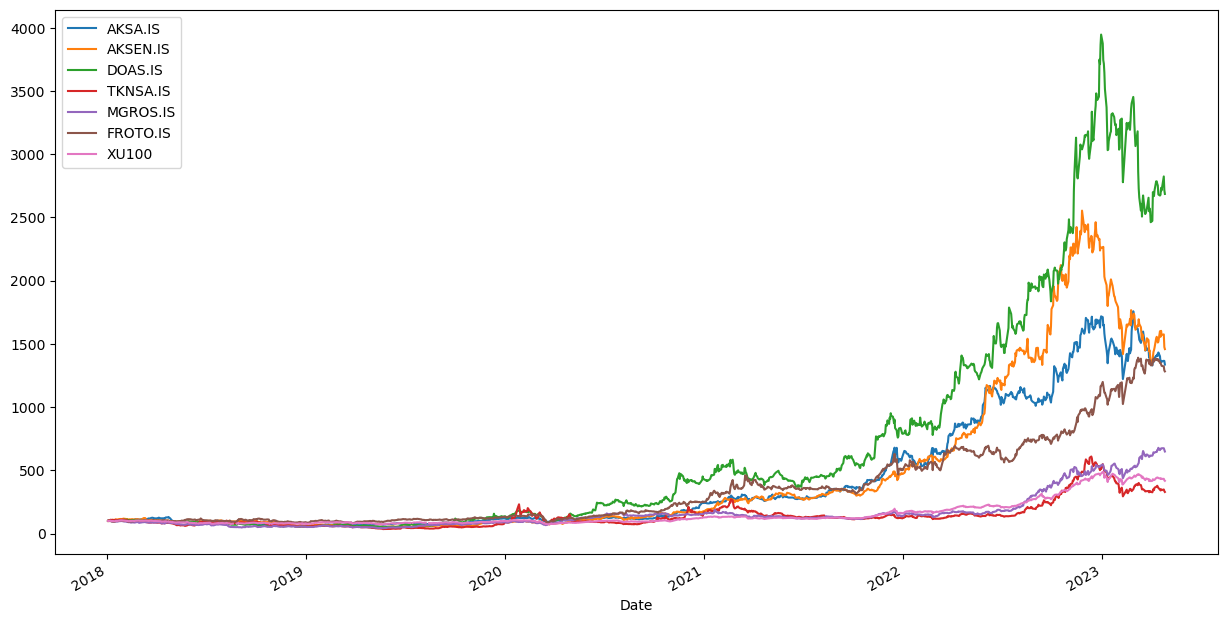

In [38]:
(mydata2/mydata2.iloc[0]*100).plot(figsize=(15,8));
plt.show()

In [39]:
mydata2.dropna(axis=0, inplace=True)
mydata2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1326 entries, 2018-01-03 to 2023-04-26
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AKSA.IS   1326 non-null   float64
 1   AKSEN.IS  1326 non-null   float64
 2   DOAS.IS   1326 non-null   float64
 3   TKNSA.IS  1326 non-null   float64
 4   MGROS.IS  1326 non-null   float64
 5   FROTO.IS  1326 non-null   float64
 6   XU100     1326 non-null   float64
dtypes: float64(7)
memory usage: 82.9 KB


## CAPM

In [40]:
sec_returns=np.log(mydata2/mydata2.shift(1))
cov=sec_returns.cov()*250
cov

,AKSA.IS,AKSEN.IS,DOAS.IS,TKNSA.IS,MGROS.IS,FROTO.IS,XU100
AKSA.IS,0.170125,0.078293,0.076850,0.078277,0.059826,0.062465,0.059964
AKSEN.IS,0.078293,0.203352,0.088546,0.085989,0.061025,0.060795,0.063394
DOAS.IS,0.076850,0.088546,0.292521,0.112190,0.073171,0.081573,0.067995
TKNSA.IS,0.078277,0.085989,0.112190,0.412072,0.079196,0.071516,0.072647
MGROS.IS,0.059826,0.061025,0.073171,0.079196,0.166221,0.055637,0.064504
FROTO.IS,0.062465,0.060795,0.081573,0.071516,0.055637,0.192463,0.066269
XU100,0.059964,0.063394,0.067995,0.072647,0.064504,0.066269,0.070066


AKSEN için Beta, sistematik ve sistematik olmayan riskler ile yıllık beklenen getirisinin hesaplanması:

In [41]:
cov_with_market=cov.iloc[1,6]
cov_with_market # Aksen'in pazar ile kovaryansı

0.06339365537449441

In [42]:
market_var=sec_returns["XU100"].var()*250
market_var # pazarın varyansı

0.07006550234285706

In [43]:
AKSEN_beta=cov_with_market/market_var
AKSEN_beta

0.9047770051556218

Bir ekonomideki tüm riskli varlıkların ortalama betası 1'dir. Bir varlığın birden büyükse o varlık çok riskli, eğer birden küçükse daha az riskli olarak kabul edilir. Beta katsayısı bir menkul kıymetin getirisinin pazar portfoyu getirisi ile olan ilişkisini gösterir.

* Toplam risk = Sistamatik risk + sistamatik olmayan risk
* Var Rit= B^2*var(Rm)+var(ei)

In [44]:
s_risk=(AKSEN_beta)**2*cov.iloc[6,6]
s_risk

0.05735712165560262

In [45]:
s_olmayan_risk=cov.iloc[1,1]-s_risk
s_olmayan_risk

0.1459943976156103

In [46]:
## CAPM
risksiz_faiz=0.1212 # 10 yıllık devlet tahvili faizi
AKSEN_er=risksiz_faiz+AKSEN_beta*((sec_returns["XU100"].mean()*250)-risksiz_faiz)
AKSEN_er

0.2553591319127006

In [47]:
## Yıllık getiri beklentisi
Sharpe=(AKSEN_er-risksiz_faiz)/(sec_returns["AKSEN.IS"].std()*250**0.5)
Sharpe

0.29750654795563897

In [58]:
risksiz_faiz=0.1212 # 10 yıllık devlet tahvili faizi
c=[]
v=[]
m_v=[]
m_c=[]
std=[]

for i,j in zip(range(0,6),sec_returns.columns[0:6]):
    c_v=round(cov.iloc[i,i],3)
    cvm=round(cov.iloc[i,6],3)
    mv=round(sec_returns["XU100"].var()*250,3)
    y_std=round(sec_returns[j].std()*250**0.5,3)
    c.append(cvm)
    m_v.append(mv)
    std.append(y_std)
    v.append(c_v)
    
sonuc=pd.DataFrame({"Hisse":sec_returns.columns[0:6],"Yıllık Standart Sapmalar":std,"Varyans":v,"Market ile kovaryansı":c,
                    "Market Varyansı":m_v})

sonuc["Beta"]=round(sonuc["Market ile kovaryansı"]/sonuc["Market Varyansı"],3)
sonuc["Sistematik Risk"]=round(sonuc["Beta"]**2*sonuc["Market Varyansı"],3)
sonuc["Sistematik Olmayan Risk"]=round(sonuc["Varyans"]-sonuc["Sistematik Risk"],3)
sonuc["CAPM"]=round(risksiz_faiz+sonuc["Beta"]*((sec_returns["XU100"].mean()*250)-risksiz_faiz),3)
sonuc["Yıllık Beklenen Getiri"]=round((sonuc["CAPM"]-risksiz_faiz)/sonuc["Yıllık Standart Sapmalar"],3)
sonuc

,Hisse,Yıllık Standart Sapmalar,Varyans,Market ile kovaryansı,Market Varyansı,Beta,Sistematik Risk,Sistematik Olmayan Risk,CAPM,Yıllık Beklenen Getiri
0,AKSA.IS,0.412,0.170,0.060,0.07,0.857,0.051,0.119,0.248,0.308
1,AKSEN.IS,0.451,0.203,0.063,0.07,0.900,0.057,0.146,0.255,0.297
2,DOAS.IS,0.541,0.293,0.068,0.07,0.971,0.066,0.227,0.265,0.266
3,TKNSA.IS,0.642,0.412,0.073,0.07,1.043,0.076,0.336,0.276,0.241
4,MGROS.IS,0.408,0.166,0.065,0.07,0.929,0.060,0.106,0.259,0.338
5,FROTO.IS,0.439,0.192,0.066,0.07,0.943,0.062,0.130,0.261,0.318


# Monte Carlo ile Fiyat tahmini:

dirf t = u-1/2*var : Hisse senedinin gelecekteki getiri oranlarının en iyi yaklaşımıdır.

* daily_returns=e^r
* r = drift+stdev*Z
* s t=s 0*daily_returns t
* s t+1=s t*daily_returns t+1
* s t+2=s t+1*daily_returns t+2

In [59]:
mydata2

,AKSA.IS,AKSEN.IS,DOAS.IS,TKNSA.IS,MGROS.IS,FROTO.IS,XU100
Date,,,,,,,
2018-01-03,5.180510,2.076936,4.626970,5.180000,27.240000,43.944771,1160.522031
2018-01-04,5.158084,2.184701,4.665946,5.240000,27.000000,43.365124,1154.912031
2018-01-05,5.221625,2.160209,4.849688,5.430000,27.120001,43.546261,1166.378984
2018-01-08,5.303855,2.214092,4.927639,5.660000,27.480000,43.183987,1163.045000
2018-01-09,5.105755,2.165107,4.916504,5.610000,26.799999,42.350735,1150.227969
2018-01-10,5.165558,2.243482,4.794009,5.450000,25.719999,41.879765,1135.895000
2018-01-11,5.225363,2.228787,4.777305,5.600000,25.900000,41.481251,1147.187969
2018-01-12,5.169297,2.253279,4.732761,5.610000,26.040001,41.336346,1146.446016
2018-01-15,4.974934,2.174904,4.649243,5.400000,25.540001,41.082748,1121.592031


In [81]:
def fiyat_tahmin(data,col):
    log_returns=np.log(1+data[col].pct_change())
    u=log_returns.mean()
    var=log_returns.var()
    drift=u-(0.5*var)
    stdev=log_returns.std()
    t_intervals=1000 # onumuzdeki 1000 gun icin fiyat tahmini..
    iterations=10 # onumuzdeki 1000 gun için 10 tane tahmin serisi elde edeceğiz.
    daily_returns=np.exp(drift+stdev*norm.ppf(np.random.rand(t_intervals,iterations)))
    S0=data[col][-1]
    price_list=np.zeros_like(daily_returns)
    price_list[0]=S0
    for t in range(1,t_intervals):
        price_list[t]=price_list[t-1]*daily_returns[t]
    price_list
    ort=[]
    for i in range(0,len(price_list)):
        ort.append(np.median(price_list[i]))
    
    return price_list,ort

In [82]:
fiyat_tahmin(mydata2,"AKSEN.IS")[0]

array([[ 30.29999924,  30.29999924,  30.29999924, ...,  30.29999924,
         30.29999924,  30.29999924],
       [ 30.17559624,  30.85167102,  29.85830829, ...,  31.82616251,
         30.48825299,  29.47177903],
       [ 29.49357014,  31.87488708,  28.44702893, ...,  30.59506625,
         29.99620496,  30.16946028],
       ...,
       [372.60158537, 248.63614429, 184.09530675, ..., 617.06195296,
         21.02233145, 226.76473492],
       [377.13377607, 244.87795124, 185.24416069, ..., 621.00510107,
         20.22328359, 223.97777647],
       [378.43156857, 232.82908955, 178.42731637, ..., 636.34426608,
         20.83889199, 230.92968523]])

In [86]:
def grafik_ciz(data,col):
    plt.figure(figsize=(15,10))
    plt.plot(data)
    plt.title("{} 1000 günlük fiyat hareketi".format(col))
    plt.xlabel("Gün")
    plt.ylabel("Fiyat")
    return plt.show()

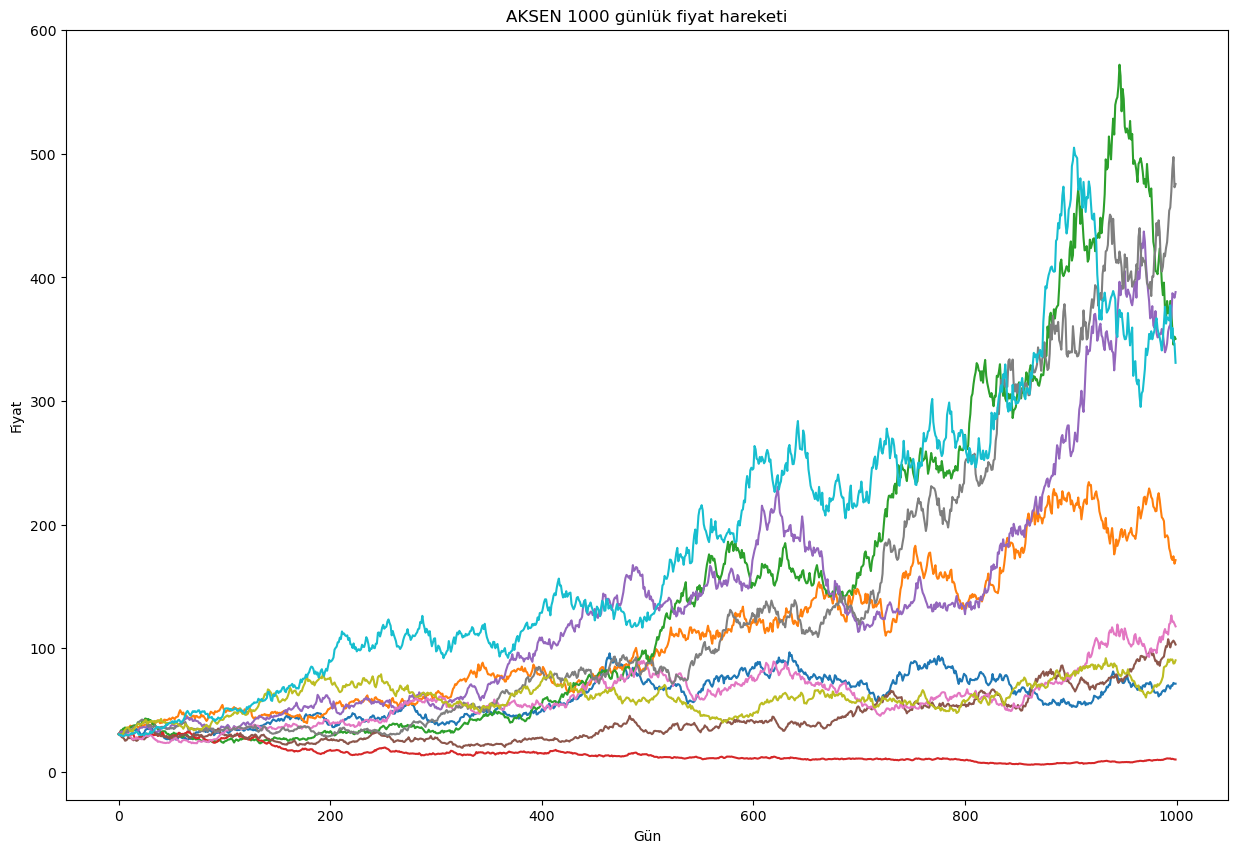

In [87]:
grafik_ciz(fiyat_tahmin(mydata2,"AKSEN.IS")[0],"AKSEN")

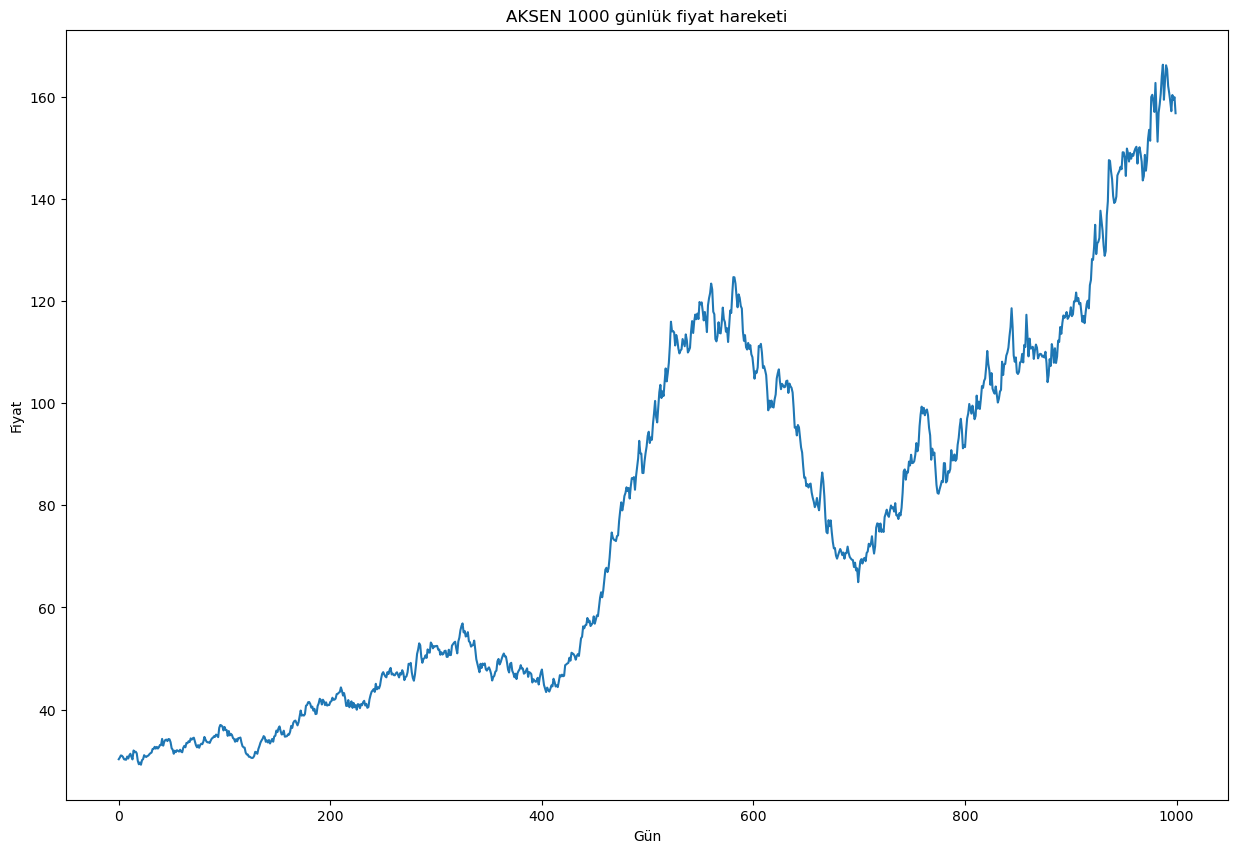

In [88]:
grafik_ciz(fiyat_tahmin(mydata2,"AKSEN.IS")[1],"AKSEN")

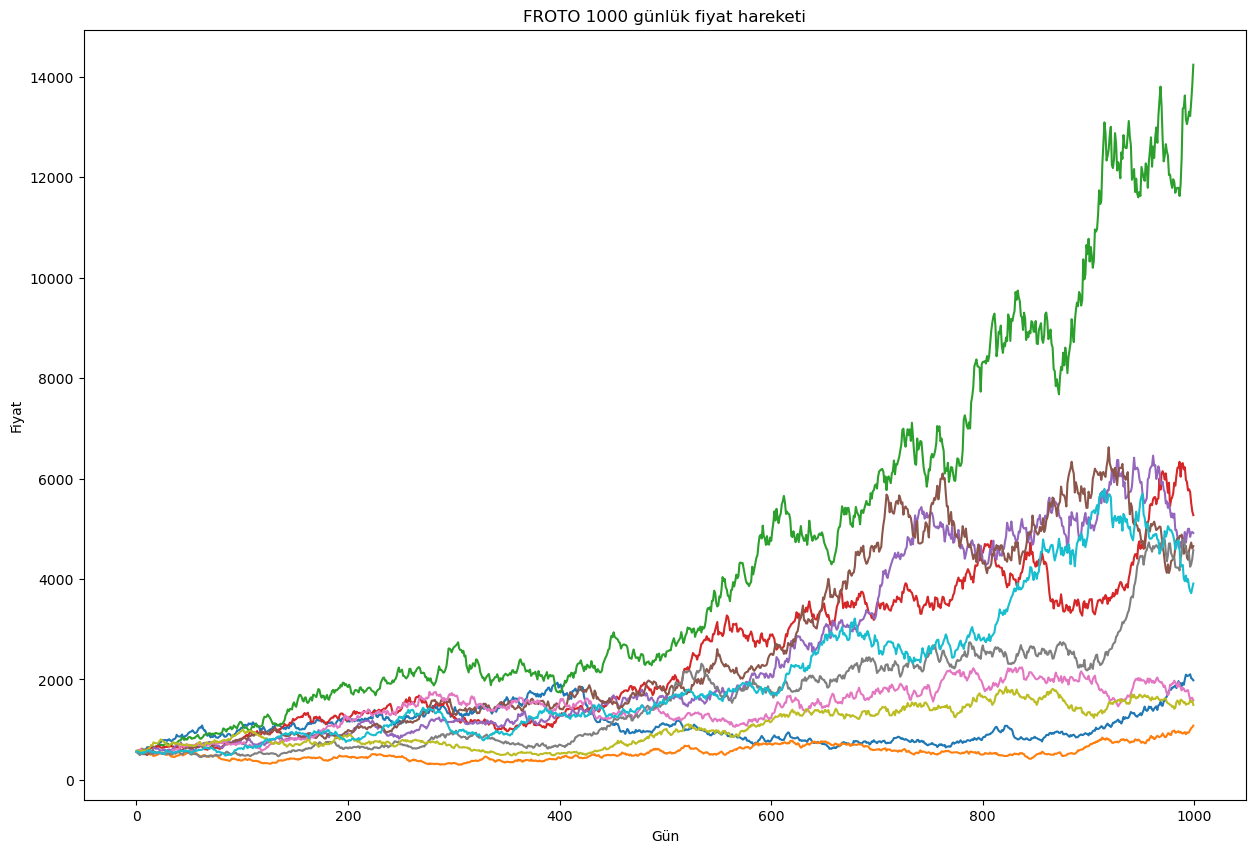

In [89]:
grafik_ciz(fiyat_tahmin(mydata2,"FROTO.IS")[0],"FROTO")

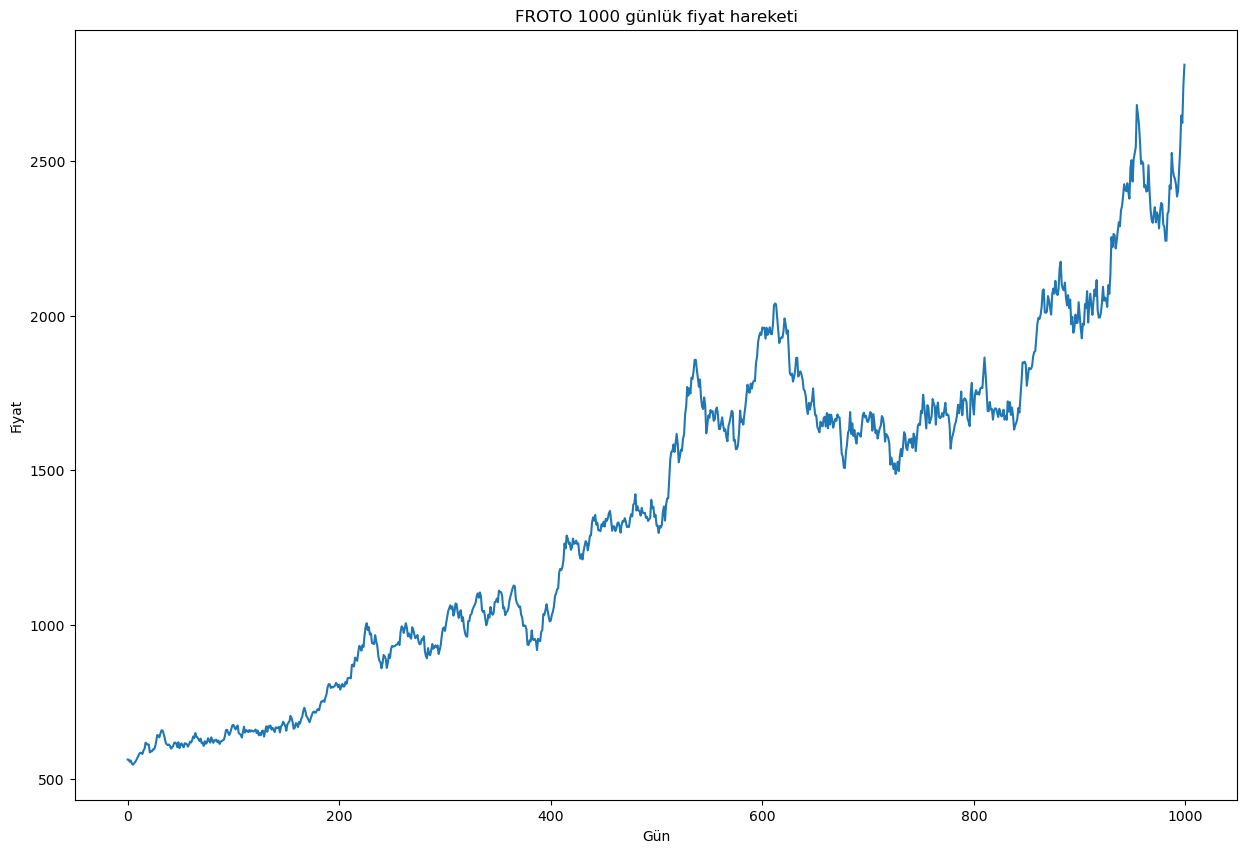

In [90]:
grafik_ciz(fiyat_tahmin(mydata2,"FROTO.IS")[1],"FROTO")